In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch

if torch.cuda.is_available():
    print(f"Currently using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("No GPU detected. Ensure CUDA is properly installed.")


Currently using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
import pandas as pd     #padhna
import numpy as np
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification, 
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import optuna

# ====================================================
# Step 1: Load and Inspect the CSV File
# ====================================================
df = pd.read_csv("dataset.csv", encoding="latin1")
print("CSV Columns:", df.columns.tolist())

# Define column names based on your dataset
TEXT_COL = "Text"    # The column with the text
LABEL_COL = "Label"  # The column with labels ("hate", "non-hate")

# Verify required columns exist
if TEXT_COL not in df.columns:
    raise KeyError(f"Column '{TEXT_COL}' not found in CSV.")
if LABEL_COL not in df.columns:
    raise KeyError(f"Column '{LABEL_COL}' not found in CSV.")

# ====================================================
# Step 2: Data Cleaning and Label Mapping
# ====================================================
def clean_text(text):
    # Basic cleaning: lower case, remove extra whitespace.
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df[TEXT_COL] = df[TEXT_COL].apply(clean_text)

# Filter out rows with invalid labels
df = df[df[LABEL_COL].isin(["hate", "non-hate"])]
print("After filtering invalid labels, dataset shape:", df.shape)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
df[LABEL_COL] = df[LABEL_COL].map(label_map).astype("int64")

# ====================================================
# Step 3: Train-Test Split
# ====================================================
# Stratified split by label to preserve distribution
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[LABEL_COL])

# ====================================================
# Step 4: Convert to Hugging Face Dataset
# ====================================================
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# ====================================================
# Step 5: Tokenization
# ====================================================
# Load the XLM-RoBERTa tokenizer.
# Note: Use "xlm-roberta-large" (without "facebook/") for public access.
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
# If you still encounter issues, ensure you are logged in with `huggingface-cli login`
def tokenize_function(example):
    return tokenizer(example[TEXT_COL], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Keep only tokenized inputs and the label column
cols_to_keep = ["input_ids", "attention_mask", LABEL_COL]
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in cols_to_keep]
)
# Rename label column to "labels" as expected by Trainer
tokenized_datasets = tokenized_datasets.rename_column(LABEL_COL, "labels")
tokenized_datasets.set_format("torch")

# ====================================================
# Step 6: Model Definition and Metrics
# ====================================================
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)
    # Ensure the model uses single-label classification (CrossEntropyLoss)
    model.config.problem_type = "single_label_classification"
    return model

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ====================================================
# Step 7: Training Arguments & Early Stopping
# ====================================================
training_args = TrainingArguments(
    output_dir='./results_XLM',
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-5,  # initial value; will be tuned
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # maximum epochs (early stopping may halt earlier)
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    weight_decay=0.01
)

# ====================================================
# Step 8: Hyperparameter Tuning using Optuna
# ====================================================
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10)
    }

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting hyperparameter search...")
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=hp_space,
    n_trials=10, 
    compute_objective=lambda metrics: metrics["eval_accuracy"]
)
print("Best hyperparameters found:", best_run.hyperparameters)

# Update training arguments with best hyperparameters
training_args.learning_rate = best_run.hyperparameters.get("learning_rate", training_args.learning_rate)
training_args.per_device_train_batch_size = best_run.hyperparameters.get("per_device_train_batch_size", training_args.per_device_train_batch_size)
training_args.num_train_epochs = best_run.hyperparameters.get("num_train_epochs", training_args.num_train_epochs)

# ====================================================
# Step 9: Final Training with Best Hyperparameters
# ====================================================
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting final training...")
trainer.train()

# ====================================================
# Step 10: Evaluation
# ====================================================
eval_results = trainer.evaluate()
print("Final evaluation results:", eval_results)


CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
After filtering invalid labels, dataset shape: (1599, 7)


Map:   0%|          | 0/1279 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

/home/srmist20/.local/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-28 10:29:51,245] A new study created in memory with name: no-name-1bfbc9ea-ce53-4875-8066-5f4d6f574d80
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can 

Starting hyperparameter search...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.687300,0.609173,0.659375,0.764952,0.659375,0.621688
100,0.441600,0.449759,0.828125,0.872093,0.828125,0.822893
150,0.376400,0.292588,0.965625,0.967103,0.965625,0.965598
200,0.188300,0.163069,0.990625,0.990644,0.990625,0.990625
250,0.020300,0.053041,0.990625,0.990798,0.990625,0.990624
300,0.001000,0.025641,0.996875,0.996894,0.996875,0.996875
350,0.146400,0.033114,0.993750,0.993827,0.993750,0.993750
400,0.000300,0.025261,0.993750,0.993827,0.993750,0.993750
450,0.000300,0.000077,1.000000,1.000000,1.000000,1.000000
500,0.000200,0.005552,0.996875,0.996894,0.996875,0.996875


[I 2025-03-28 10:33:41,053] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 4.249275021718003e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5}. Best is trial 0 with value: 1.0.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.695600,0.696123,0.500000,0.250000,0.500000,0.333333
100,0.732800,0.664330,0.615625,0.770098,0.615625,0.551499
150,0.688200,0.615604,0.778125,0.780591,0.778125,0.777636
200,0.584100,0.527189,0.846875,0.846997,0.846875,0.846862
250,0.603400,0.492745,0.871875,0.886379,0.871875,0.870661
300,0.575600,0.408866,0.928125,0.930970,0.928125,0.928006
350,0.405800,0.311969,0.984375,0.984394,0.984375,0.984375
400,0.263700,0.251494,0.984375,0.984394,0.984375,0.984375
450,0.326600,0.167329,0.990625,0.990644,0.990625,0.990625
500,0.119800,0.052496,0.990625,0.990644,0.990625,0.990625


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-03-28 10:37:45,507] Trial 1 finished with value: 0.996875 and parameters: {'learning_rate': 1.9088104755450897e-06, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}. Best is trial 0 with value: 1.0.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You shoul

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.673600,0.481259,0.696875,0.811284,0.696875,0.666204
100,0.317800,0.264291,0.984375,0.984545,0.984375,0.984374
150,0.073300,0.017897,1.000000,1.000000,1.000000,1.000000
200,0.100800,0.025271,0.996875,0.996894,0.996875,0.996875
250,0.000300,0.042686,0.993750,0.993827,0.993750,0.993750
300,0.000200,0.031570,0.993750,0.993827,0.993750,0.993750


[I 2025-03-28 10:39:43,538] Trial 2 finished with value: 0.99375 and parameters: {'learning_rate': 5.739976295528299e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 8}. Best is trial 0 with value: 1.0.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.854600,0.718590,0.500000,0.250000,0.500000,0.333333
100,0.821600,0.693444,0.500000,0.250000,0.500000,0.333333
150,0.701500,0.719787,0.500000,0.250000,0.500000,0.333333
200,0.735900,0.701391,0.500000,0.250000,0.500000,0.333333


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.696900,0.697902,0.500000,0.250000,0.500000,0.333333
100,0.706800,0.699216,0.500000,0.250000,0.500000,0.333333
150,0.707300,0.703338,0.500000,0.250000,0.500000,0.333333
200,0.729200,0.699371,0.500000,0.250000,0.500000,0.333333


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.696300,0.699870,0.500000,0.250000,0.500000,0.333333
100,0.721700,0.672509,0.631250,0.632932,0.631250,0.630080
150,0.697200,0.649216,0.721875,0.765731,0.721875,0.709906


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-03-28 10:43:22,935] Trial 5 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.744300,0.695017,0.500000,0.250000,0.500000,0.333333
100,0.805200,0.694349,0.500000,0.250000,0.500000,0.333333


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-03-28 10:43:51,106] Trial 6 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-rob

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.514500,0.392254,0.921875,0.932432,0.921875,0.921395
100,0.053400,0.016620,1.000000,1.000000,1.000000,1.000000
150,0.004200,0.002582,1.000000,1.000000,1.000000,1.000000
200,0.075400,0.018905,0.996875,0.996894,0.996875,0.996875


[I 2025-03-28 10:45:54,478] Trial 7 finished with value: 0.996875 and parameters: {'learning_rate': 7.00982194174652e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 1.0.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.688400,0.684185,0.543750,0.706034,0.543750,0.431879


[I 2025-03-28 10:46:16,116] Trial 8 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.197600,0.153844,0.956250,0.956535,0.956250,0.956243
100,0.778700,0.594064,0.659375,0.788319,0.659375,0.616497
150,0.693400,0.726325,0.500000,0.250000,0.500000,0.333333
200,0.776300,0.696474,0.500000,0.250000,0.500000,0.333333


/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/srmist20/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-03-28 10:47:36,019] Trial 9 finished with value: 0.5 and parameters: {'learning_rate': 2.4529211728617886e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 7}. Best is trial 0 with value: 1.0.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended 

Best hyperparameters found: {'learning_rate': 4.249275021718003e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 5}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting final training...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.687300,0.609173,0.659375,0.764952,0.659375,0.621688
100,0.441600,0.449759,0.828125,0.872093,0.828125,0.822893
150,0.376400,0.292588,0.965625,0.967103,0.965625,0.965598
200,0.188300,0.163069,0.990625,0.990644,0.990625,0.990625
250,0.020300,0.053041,0.990625,0.990798,0.990625,0.990624
300,0.001000,0.025641,0.996875,0.996894,0.996875,0.996875
350,0.146400,0.033114,0.993750,0.993827,0.993750,0.993750
400,0.000300,0.025261,0.993750,0.993827,0.993750,0.993750
450,0.000300,0.000077,1.000000,1.000000,1.000000,1.000000
500,0.000200,0.005552,0.996875,0.996894,0.996875,0.996875


Final evaluation results: {'eval_loss': 7.720693247392774e-05, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 1.8849, 'eval_samples_per_second': 169.771, 'eval_steps_per_second': 21.221, 'epoch': 3.75}


In [10]:
trainer.save_model("./results_XLM")
tokenizer.save_pretrained("./results_XLM")


('./results_XLM/tokenizer_config.json',
 './results_XLM/special_tokens_map.json',
 './results_XLM/sentencepiece.bpe.model',
 './results_XLM/added_tokens.json',
 './results_XLM/tokenizer.json')

In [11]:
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved tokenizer not found. Loading tokenizer from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()


Loading tokenizer from saved directory.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

In [12]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset

# ------------------------------------------
# Step 1: Load and Preprocess the Test CSV
# ------------------------------------------
test_df = pd.read_csv("Data final.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)

# Drop rows with missing or invalid labels
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------
# Step 2: Create a Custom Dataset for Test Data
# ------------------------------------------
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["Text"]
        inputs = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Squeeze to remove extra batch dimension and add the label
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(int(self.df.iloc[idx]["Label"]))
        return item

# ------------------------------------------
# Step 3: Load Model and Tokenizer from ./results_XLM
# ------------------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    raise EnvironmentError(f"Saved model/tokenizer not found in {saved_model_dir}.")

# Ensure the model uses CrossEntropyLoss for single-label classification.
model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------------------
# Step 4: Create DataLoader for Test Dataset
# ------------------------------------------
test_dataset = TestDataset(test_df, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=8)

# ------------------------------------------
# Step 5: Run Inference and Evaluate
# ------------------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Only pass the required inputs to the model
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch["labels"].numpy()
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds)
        all_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (467, 7)
Loading tokenizer and model from saved directory: ./results_XLM

Classification Report:
              precision    recall  f1-score   support

    non-hate       0.88      0.86      0.87       231
        hate       0.87      0.89      0.88       236

    accuracy                           0.88       467
   macro avg       0.88      0.88      0.88       467
weighted avg       0.88      0.88      0.88       467

Confusion Matrix:
[[199  32]
 [ 26 210]]


In [1]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset

# ------------------------------------------
# Step 1: Load and Preprocess the Test CSV
# ------------------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)

# Drop rows with missing or invalid labels
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------
# Step 2: Create a Custom Dataset for Test Data
# ------------------------------------------
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["Text"]
        inputs = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Squeeze to remove extra batch dimension and add the label
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(int(self.df.iloc[idx]["Label"]))
        return item

# ------------------------------------------
# Step 3: Load Model and Tokenizer from ./results_XLM
# ------------------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    raise EnvironmentError(f"Saved model/tokenizer not found in {saved_model_dir}.")

# Ensure the model uses CrossEntropyLoss for single-label classification.
model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------------------
# Step 4: Create DataLoader for Test Dataset
# ------------------------------------------
test_dataset = TestDataset(test_df, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=8)

# ------------------------------------------
# Step 5: Run Inference and Evaluate
# ------------------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Only pass the required inputs to the model
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch["labels"].numpy()
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds)
        all_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)
Loading tokenizer and model from saved directory: ./results_XLM


2025-03-28 11:58:10.580895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743143290.597466 2871083 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743143290.602859 2871083 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743143290.616455 2871083 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743143290.616472 2871083 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743143290.616474 2871083 computation_placer.cc:177] computation placer alr


Classification Report:
              precision    recall  f1-score   support

    non-hate       0.91      1.00      0.95        50
        hate       1.00      0.90      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

Confusion Matrix:
[[50  0]
 [ 5 45]]


In [1]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Load your saved model and tokenizer
# ------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------
# Load and preprocess the test CSV
# ------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map labels: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------
# Define prompting functions
# ------------------------------
def zero_shot_prompt(text):
    # Zero-shot: simply prepend an instruction.
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text, examples):
    # Few-shot: include a few examples in the prompt.
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        prompt += f"Text: {ex_text}\nLabel: {ex_label}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    # Chain-of-thought: instruct the model to think step by step.
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# Define a few-shot example list (tweak these examples as needed)
few_shot_examples = [
    ("i hate when people are rude", "hate"),
    ("i love when people are kind", "non-hate")
]

# ------------------------------
# Function to run inference with a given prompt function
# ------------------------------
def run_prompt_inference(df, prompt_func, **kwargs):
    all_preds = []
    all_labels = []
    for idx, row in df.iterrows():
        original_text = row["Text"]
        true_label = int(row["Label"])
        # Create the prompt using the provided function (pass additional arguments if needed)
        if kwargs:
            prompt_text = prompt_func(original_text, **kwargs)
        else:
            prompt_text = prompt_func(original_text)
        # Tokenize the prompt
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        pred = np.argmax(logits, axis=-1)[0]
        all_preds.append(pred)
        all_labels.append(true_label)
    return all_preds, all_labels

# ------------------------------
# Run inference for each prompting technique
# ------------------------------
zero_preds, zero_labels = run_prompt_inference(test_df, zero_shot_prompt)
few_preds, few_labels = run_prompt_inference(test_df, few_shot_prompt, examples=few_shot_examples)
cot_preds, cot_labels = run_prompt_inference(test_df, chain_of_thought_prompt)

# ------------------------------
# Evaluate and visualize results
# ------------------------------
print("Zero-Shot Prompting Results:")
print(classification_report(zero_labels, zero_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(zero_labels, zero_preds))

print("\nFew-Shot Prompting Results:")
print(classification_report(few_labels, few_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(few_labels, few_preds))

print("\nChain-of-Thought Prompting Results:")
print(classification_report(cot_labels, cot_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(cot_labels, cot_preds))


Loading tokenizer and model from saved directory: ./results_XLM


2025-04-01 11:31:06.144650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743487266.163081  888885 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743487266.169049  888885 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743487266.183952  888885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743487266.183967  888885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743487266.183969  888885 computation_placer.cc:177] computation placer alr

Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)
Zero-Shot Prompting Results:
              precision    recall  f1-score   support

    non-hate       0.98      0.80      0.88        50
        hate       0.83      0.98      0.90        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

Confusion Matrix:
[[40 10]
 [ 1 49]]

Few-Shot Prompting Results:
              precision    recall  f1-score   support

    non-hate       0.86      1.00      0.93        50
        hate       1.00      0.84      0.91        50

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100

Confusion Matrix:
[[50  0]
 [ 8 42]]

Chain-of-Thought Prompting Results:
              precision    recall  

In [2]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Step 1: Load and Prepare the Fine-Tuned Model & Tokenizer
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode!")

# ------------------------------
# Step 2: Define Refined Prompt Templates
# ------------------------------
# High-quality prompt templates for each strategy
def zero_shot_prompt(text):
    return f"You are an expert in analyzing online content in Hinglish (a mix of Hindi and English). " \
           f"Please classify the following text as either 'Hate Speech' or 'Non-Hate Speech'.\n\n" \
           f"Text: \"{text}\"\n\nAnswer:"

def few_shot_prompt(text, examples):
    prompt = "Below are examples of classifying Hinglish texts:\n\n"
    for ex_text, ex_label in examples:
        prompt += f"Text: \"{ex_text}\"\nClassification: {ex_label}\n\n"
    prompt += f"Now, classify the following text accordingly:\nText: \"{text}\"\n\nAnswer:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Analyze the following Hinglish text step by step and provide your reasoning before giving the final classification.\n" \
           f"Consider both Hindi and English parts, cultural nuances, and slang. If the text includes insults or promotes harm, " \
           f"classify it as 'Hate Speech'; otherwise, classify it as 'Non-Hate Speech'.\n\n" \
           f"Text: \"{text}\"\n\nReasoning: [Explain your thought process here]\n\nFinal Classification (Answer only 'Hate Speech' or 'Non-Hate Speech'):"

# Define few-shot examples (adjust as needed)
few_shot_examples = [
    ("Tum log bohot badtameez ho", "Hate Speech"),
    ("I love spending time with my family", "Non-Hate Speech")
]

# Dictionary of prompt functions for easier iteration
prompt_functions = {
    "zero_shot": zero_shot_prompt,
    "few_shot": lambda text: few_shot_prompt(text, few_shot_examples),
    "chain_of_thought": chain_of_thought_prompt
}

# ------------------------------
# Step 3: Load and Preprocess the Test Dataset
# ------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)
label_map_csv = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map_csv)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------
# Step 4: Ensemble Inference using Multiple Prompting Methods
# ------------------------------
def ensemble_classify(text, prompt_funcs):
    """
    For a given text, run each prompting method and return the final ensemble prediction
    using majority voting. If there is a tie, default to zero_shot prediction.
    """
    preds = []
    for key, prompt_func in prompt_funcs.items():
        prompt_text = prompt_func(text)
        inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=-1).item()
        preds.append(pred_class)
    # Majority vote
    preds_array = np.array(preds)
    # If tie, use zero_shot prediction as default (index 0 in list)
    if np.sum(preds_array == 0) == np.sum(preds_array == 1):
        final_pred = preds[0]  # default to first method (zero_shot if ordering preserved)
    else:
        final_pred = int(np.round(np.mean(preds_array)))
    return final_pred, preds  # returning final prediction and individual predictions for analysis

all_preds = []
all_labels = []

for idx, row in test_df.iterrows():
    text = row["Text"]
    true_label = int(row["Label"])
    final_pred, individual_preds = ensemble_classify(text, prompt_functions)
    all_preds.append(final_pred)
    all_labels.append(true_label)

# ------------------------------
# Step 5: Evaluate and Visualize the Results
# ------------------------------
print("\nEnsembled Prompting Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Loading tokenizer and model from saved directory: ./results_XLM
Model loaded and set to evaluation mode!
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)

Ensembled Prompting Classification Report:
              precision    recall  f1-score   support

    non-hate       0.81      0.94      0.87        50
        hate       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

Confusion Matrix:
[[47  3]
 [11 39]]


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Load your saved model and tokenizer
# ------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------
# Load and preprocess the test CSV
# ------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map labels: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------
# Define prompting functions
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text, examples):
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        prompt += f"Text: {ex_text}\nLabel: {ex_label}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# Define few-shot examples
few_shot_examples = [
    ("i hate when people are rude", "hate"),
    ("i love when people are kind", "non-hate")
]

# ------------------------------
# Run inference for all prompting methods and combine results
# ------------------------------
def run_combined_inference(df):
    all_preds = []
    all_labels = []
    for idx, row in df.iterrows():
        original_text = row["Text"]
        true_label = int(row["Label"])

        # Generate prompts
        zero_prompt = zero_shot_prompt(original_text)
        few_prompt = few_shot_prompt(original_text, few_shot_examples)
        cot_prompt = chain_of_thought_prompt(original_text)

        # Tokenize and predict for each prompt
        prompts = [zero_prompt, few_prompt, cot_prompt]
        predictions = []
        
        for prompt in prompts:
            inputs = tokenizer(prompt, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy()
            pred = np.argmax(logits, axis=-1)[0]
            predictions.append(pred)
        
        # Majority voting (or averaging for softer decisions)
        final_pred = round(np.mean(predictions))
        all_preds.append(final_pred)
        all_labels.append(true_label)
    
    return all_preds, all_labels

# Run combined inference
final_preds, final_labels = run_combined_inference(test_df)

# ------------------------------
# Evaluate and visualize results
# ------------------------------
print("Final Combined Model Results:")
print(classification_report(final_labels, final_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(final_labels, final_preds))

Loading tokenizer and model from saved directory: ./results_XLM


2025-04-04 16:37:05.996854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743764826.039867 4093112 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743764826.052068 4093112 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743764826.115549 4093112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743764826.115580 4093112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743764826.115582 4093112 computation_placer.cc:177] computation placer alr

Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)


In [3]:
import os
import torch
import pandas as pd
import numpy as np
import re
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sentence_transformers import SentenceTransformer

# ------------------------------
# Step 1: Load and Analyze Dataset
# ------------------------------
file_path = "dataset.csv"
df = pd.read_csv(file_path, encoding="latin1")

# Display dataset overview
print("Dataset Overview:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Label distribution
print("\nLabel Distribution:")
print(df["Label"].value_counts())

# Data Cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df["Text"] = df["Text"].apply(clean_text)

# Map labels: "hate" -> 1, "non-hate" -> 0
label_map = {"hate": 1, "non-hate": 0}
df["Label"] = df["Label"].map(label_map)
df = df.dropna(subset=["Label"])

# ------------------------------
# Step 2: Load Model & Tokenizer
# ------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------
# Step 3: Build FAISS Vector Store for Retrieval (RAG)
# ------------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df["Text"].tolist()
labels = df["Label"].tolist()

# Convert texts to embeddings
embeddings = embedding_model.encode(texts, convert_to_numpy=True)

# Create FAISS index
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

def retrieve_similar_examples(query_text, top_k=3):
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    distances, indices = faiss_index.search(query_embedding, top_k)
    examples = [(texts[i], labels[i]) for i in indices[0]]
    return examples

# ------------------------------
# Step 4: Define Prompting Techniques with RAG
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# ------------------------------
# Step 5: Run Combined RAG + Prompting Classification
# ------------------------------
def run_inference(df, prompt_func):
    all_preds = []
    all_labels = []
    all_probs = []  # For ROC curve
    for _, row in df.iterrows():
        text, true_label = row["Text"], int(row["Label"])
        prompt_text = prompt_func(text)
        
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        
        pred = np.argmax(logits, axis=-1)[0]
        
        all_preds.append(pred)
        all_labels.append(true_label)
        all_probs.append(probs[0][1])  # Store probability of "hate" class
    
    return all_preds, all_labels, all_probs

# ------------------------------
# Step 6: Evaluation & Visualization
# ------------------------------
def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred, target_names=["non-hate", "hate"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-hate", "hate"], yticklabels=["non-hate", "hate"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

# Run all methods
zero_preds, zero_labels, zero_probs = run_inference(df, zero_shot_prompt)
few_preds, few_labels, few_probs = run_inference(df, few_shot_prompt)
cot_preds, cot_labels, cot_probs = run_inference(df, chain_of_thought_prompt)

# Evaluate all methods
evaluate_model("Zero-Shot", zero_labels, zero_preds, zero_probs)
evaluate_model("Few-Shot (RAG)", few_labels, few_preds, few_probs)
evaluate_model("Chain-of-Thought", cot_labels, cot_preds, cot_probs)


2025-04-04 17:01:40.838893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743766300.859447 4123167 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743766300.866115 4123167 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743766300.882798 4123167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743766300.882812 4123167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743766300.882813 4123167 computation_placer.cc:177] computation placer alr

Dataset Overview:
   ID                                               Text     Label  \
0   1  Ye Modi aur uske chamche desh ko barbad kar ra...      hate   
1   2  Kal ki movie bohot achi thi, acting aur story ...  non-hate   
2   3  Aaj ka weather kaisa hai? Bahar jane ka mood n...  non-hate   
3   4  Tum jaise logon ki wajah se hi desh ka bera ga...      hate   
4   5  Tumhara dimaag kharab hai kya? Itna ganda comm...      hate   

                                       Parent_Text       Hashtags  \
0                                              NaN      #politics   
1                                              NaN        #movies   
2                                              NaN    #daily life   
3  I think the new policy is good for the economy.      #politics   
4                                              NaN  #social media   

  Language_Script Sentiment  
0           Mixed  Negative  
1           Mixed  Positive  
2           Mixed   Neutral  
3           Mixed  Negativ

KeyboardInterrupt: 

Loading tokenizer and model from saved directory: ./results_XLM
Using device: cuda

---- EVALUATION ON TRAIN DATA ----

Zero-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.94      0.97       800
        hate       0.94      1.00      0.97       799

    accuracy                           0.97      1599
   macro avg       0.97      0.97      0.97      1599
weighted avg       0.97      0.97      0.97      1599



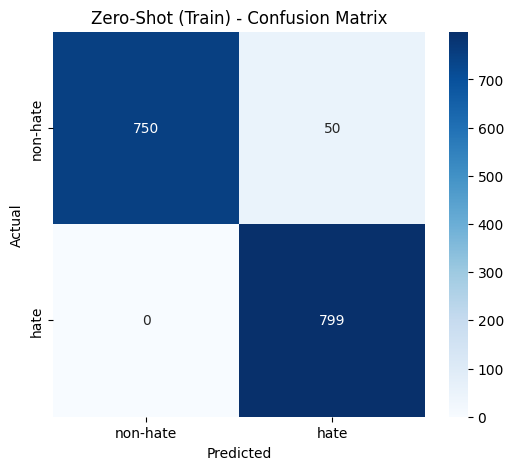

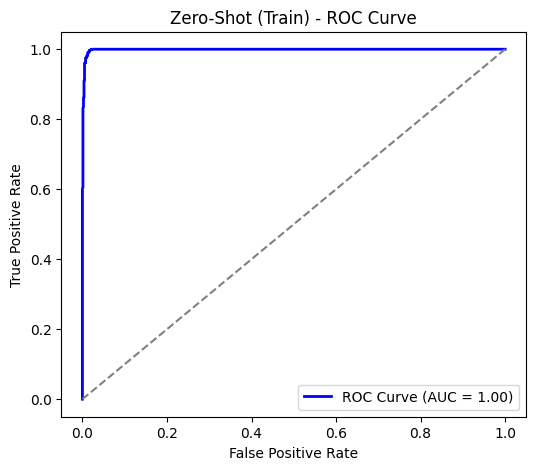

Zero-Shot (Train) Accuracy: 0.9687

Few-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.97      0.93      0.95       800
        hate       0.93      0.97      0.95       799

    accuracy                           0.95      1599
   macro avg       0.95      0.95      0.95      1599
weighted avg       0.95      0.95      0.95      1599



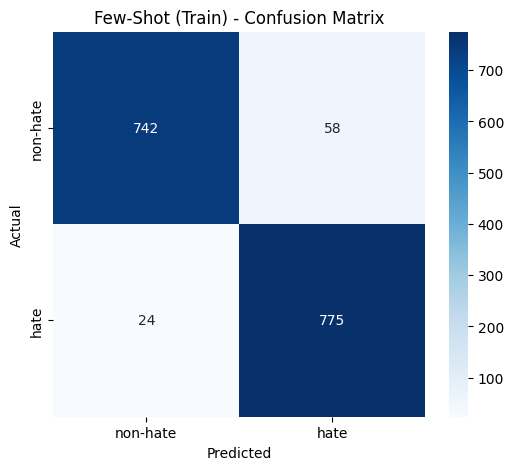

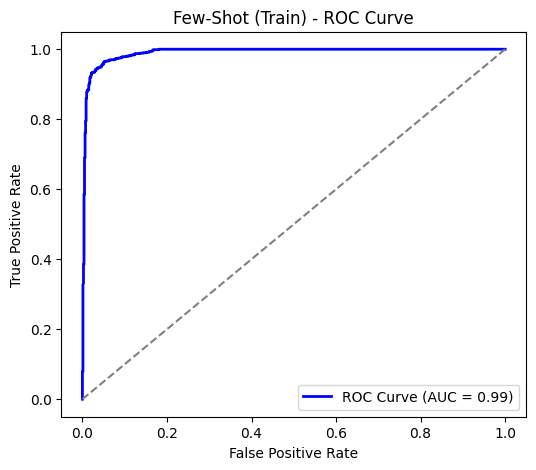

Few-Shot (Train) Accuracy: 0.9487

Chain-of-Thought (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.98      0.99       800
        hate       0.98      1.00      0.99       799

    accuracy                           0.99      1599
   macro avg       0.99      0.99      0.99      1599
weighted avg       0.99      0.99      0.99      1599



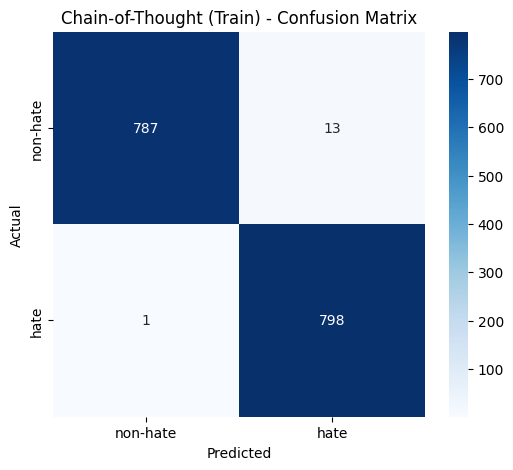

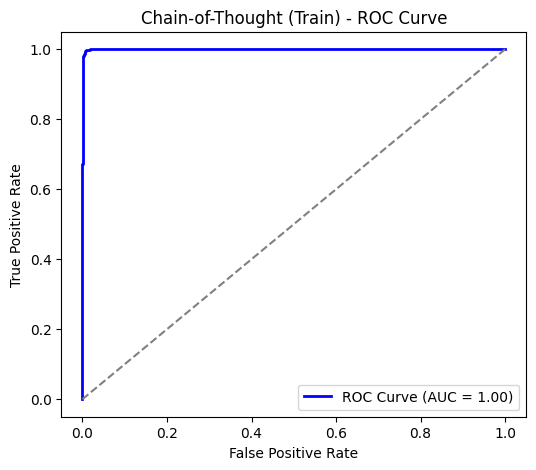

Chain-of-Thought (Train) Accuracy: 0.9912

---- EVALUATION ON TEST DATA ----

Zero-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.98      0.80      0.88        50
        hate       0.83      0.98      0.90        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100



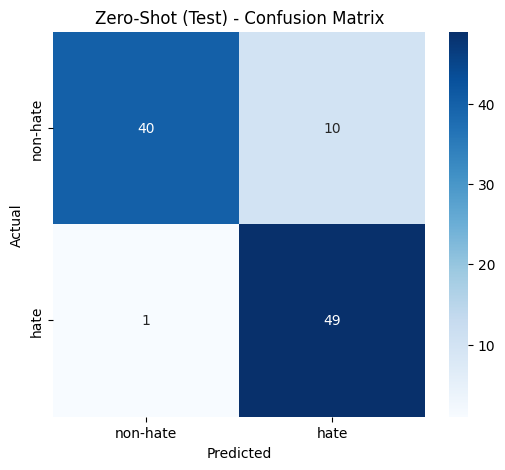

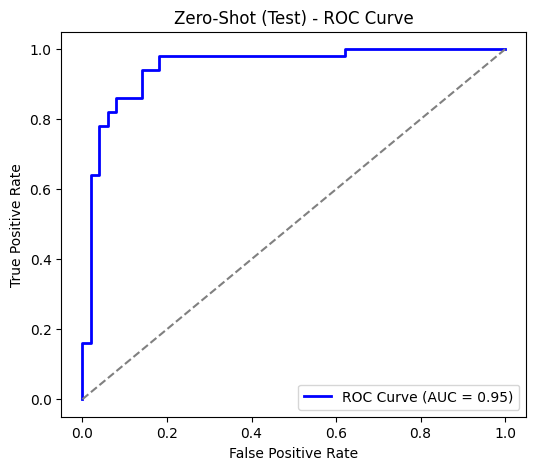

Zero-Shot (Test) Accuracy: 0.8900

Few-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.76      0.78      0.77        50
        hate       0.78      0.76      0.77        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



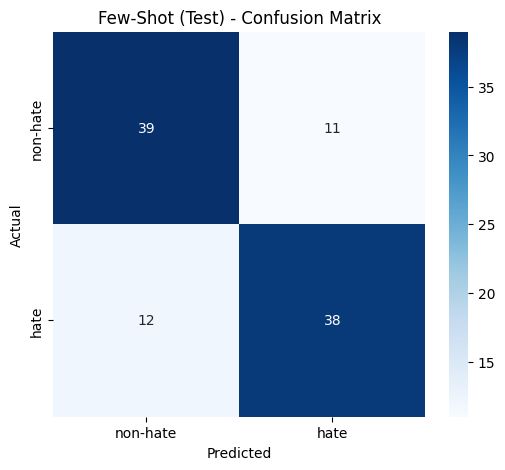

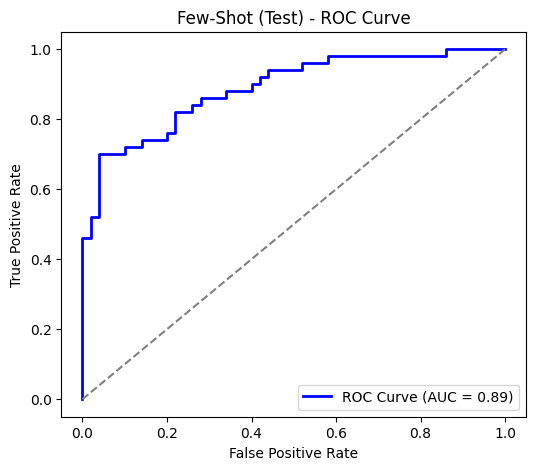

Few-Shot (Test) Accuracy: 0.7700

Chain-of-Thought (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.92      0.96      0.94        50
        hate       0.96      0.92      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



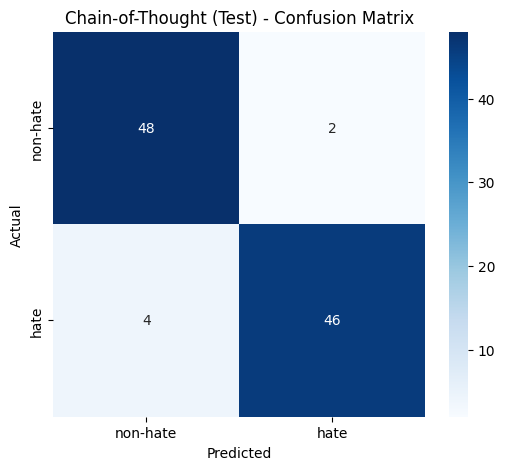

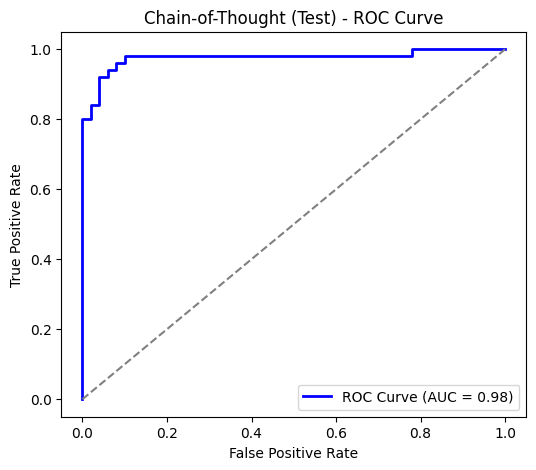

Chain-of-Thought (Test) Accuracy: 0.9400


In [8]:
import os
import torch
import pandas as pd
import numpy as np
import re
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sentence_transformers import SentenceTransformer
from lime.lime_text import LimeTextExplainer

# ------------------------------
# Load and Preprocess Dataset
# ------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, encoding="latin1")
    
    # Data Cleaning
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df["Text"] = df["Text"].apply(clean_text)
    
    # Convert labels: "hate" -> 1, "non-hate" -> 0
    label_map = {"hate": 1, "non-hate": 0}
    df["Label"] = df["Label"].map(label_map)
    df = df.dropna(subset=["Label"])
    
    return df

train_file_path = "dataset.csv"
test_file_path = "TEST.csv"

df_train = load_and_preprocess(train_file_path)
df_test = load_and_preprocess(test_file_path)

# ------------------------------
# Load Model & Tokenizer
# ------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------
# FAISS-based RAG Setup
# ------------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df_train["Text"].tolist()
labels = df_train["Label"].tolist()

# Convert texts to embeddings
embeddings = embedding_model.encode(texts, convert_to_numpy=True)

# Create FAISS index
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

def retrieve_similar_examples(query_text, top_k=3):
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    distances, indices = faiss_index.search(query_embedding, top_k)
    examples = [(texts[i], labels[i]) for i in indices[0]]
    return examples

# ------------------------------
# Define Prompting Techniques with RAG
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# ------------------------------
# Run Inference Function
# ------------------------------
def run_inference(df, prompt_func):
    all_preds = []
    all_labels = []
    all_probs = []  # For ROC curve
    for _, row in df.iterrows():
        text, true_label = row["Text"], int(row["Label"])
        prompt_text = prompt_func(text)
        
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        
        pred = np.argmax(logits, axis=-1)[0]
        
        all_preds.append(pred)
        all_labels.append(true_label)
        all_probs.append(probs[0][1])  # Store probability of "hate" class
    
    return all_preds, all_labels, all_probs

# ------------------------------
# Model Evaluation Function
# ------------------------------
def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred, target_names=["non-hate", "hate"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-hate", "hate"], yticklabels=["non-hate", "hate"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

# ------------------------------
# Run Evaluations on Train & Test Sets
# ------------------------------
# Train Data Evaluation
zero_preds_train, zero_labels_train, zero_probs_train = run_inference(df_train, zero_shot_prompt)
few_preds_train, few_labels_train, few_probs_train = run_inference(df_train, few_shot_prompt)
cot_preds_train, cot_labels_train, cot_probs_train = run_inference(df_train, chain_of_thought_prompt)

# Test Data Evaluation
zero_preds_test, zero_labels_test, zero_probs_test = run_inference(df_test, zero_shot_prompt)
few_preds_test, few_labels_test, few_probs_test = run_inference(df_test, few_shot_prompt)
cot_preds_test, cot_labels_test, cot_probs_test = run_inference(df_test, chain_of_thought_prompt)

# Display Evaluation Results
print("\n---- EVALUATION ON TRAIN DATA ----")
evaluate_model("Zero-Shot (Train)", zero_labels_train, zero_preds_train, zero_probs_train)
evaluate_model("Few-Shot (Train)", few_labels_train, few_preds_train, few_probs_train)
evaluate_model("Chain-of-Thought (Train)", cot_labels_train, cot_preds_train, cot_probs_train)

print("\n---- EVALUATION ON TEST DATA ----")
evaluate_model("Zero-Shot (Test)", zero_labels_test, zero_preds_test, zero_probs_test)
evaluate_model("Few-Shot (Test)", few_labels_test, few_preds_test, few_probs_test)
evaluate_model("Chain-of-Thought (Test)", cot_labels_test, cot_preds_test, cot_probs_test)

Loading tokenizer and model from saved directory: ./results_XLM
Using device: cuda

---- EVALUATION ON TRAIN DATA ----

Zero-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.94      0.97       800
        hate       0.94      1.00      0.97       799

    accuracy                           0.97      1599
   macro avg       0.97      0.97      0.97      1599
weighted avg       0.97      0.97      0.97      1599



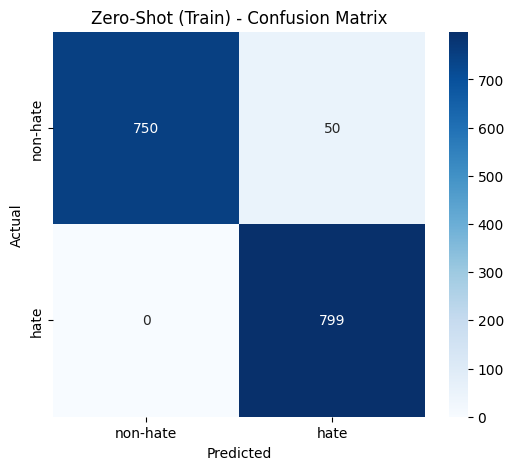

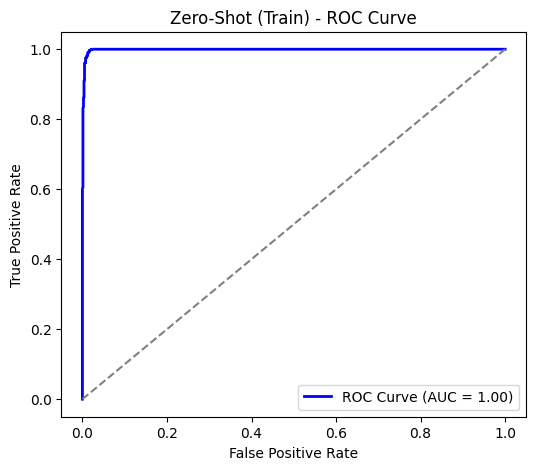

Zero-Shot (Train) Accuracy: 0.9687

Few-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.97      0.93      0.95       800
        hate       0.93      0.97      0.95       799

    accuracy                           0.95      1599
   macro avg       0.95      0.95      0.95      1599
weighted avg       0.95      0.95      0.95      1599



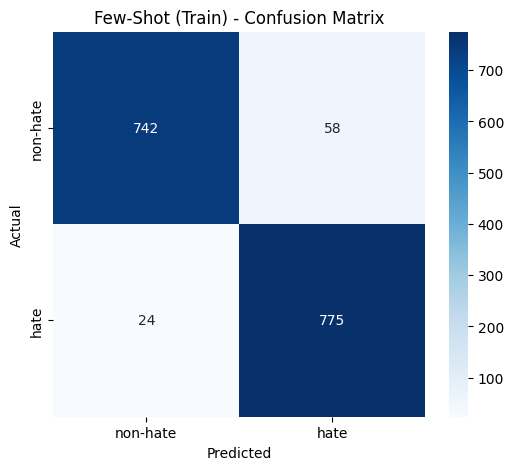

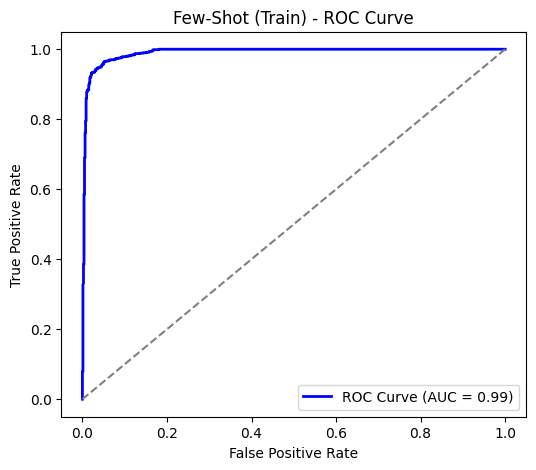

Few-Shot (Train) Accuracy: 0.9487

Chain-of-Thought (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.98      0.99       800
        hate       0.98      1.00      0.99       799

    accuracy                           0.99      1599
   macro avg       0.99      0.99      0.99      1599
weighted avg       0.99      0.99      0.99      1599



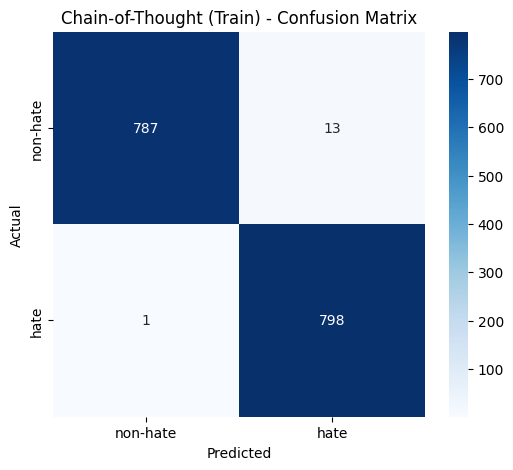

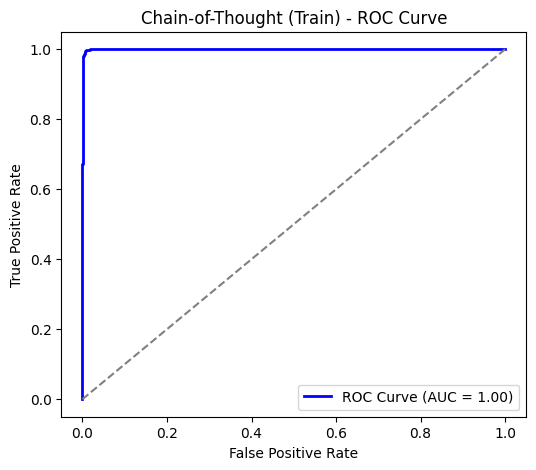

Chain-of-Thought (Train) Accuracy: 0.9912

Combined Prompting (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.96      0.94      0.95       800
        hate       0.94      0.96      0.95       799

    accuracy                           0.95      1599
   macro avg       0.95      0.95      0.95      1599
weighted avg       0.95      0.95      0.95      1599



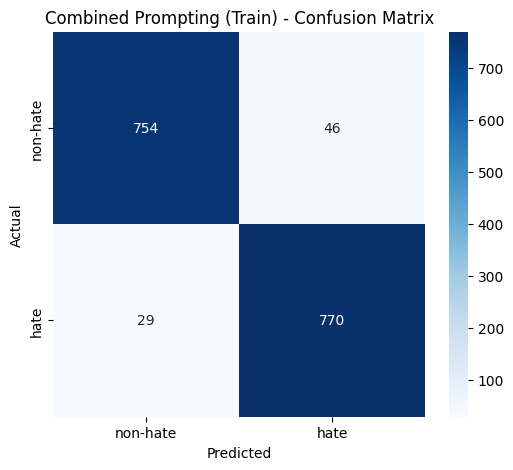

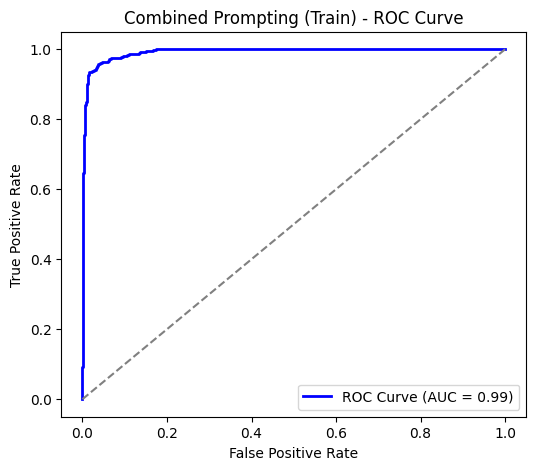

Combined Prompting (Train) Accuracy: 0.9531

---- EVALUATION ON TEST DATA ----

Zero-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.98      0.80      0.88        50
        hate       0.83      0.98      0.90        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100



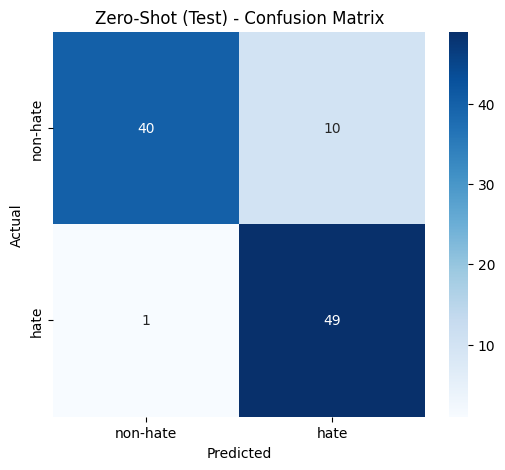

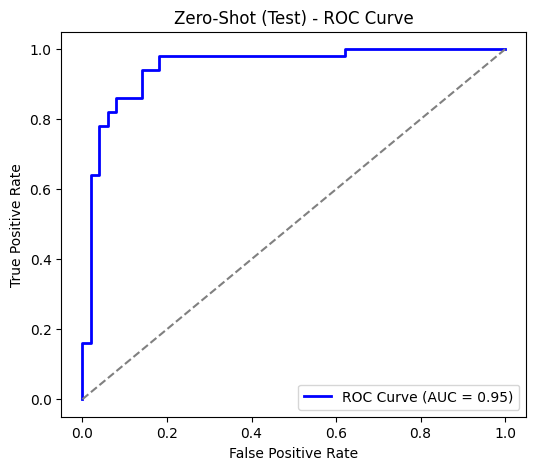

Zero-Shot (Test) Accuracy: 0.8900

Few-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.76      0.78      0.77        50
        hate       0.78      0.76      0.77        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



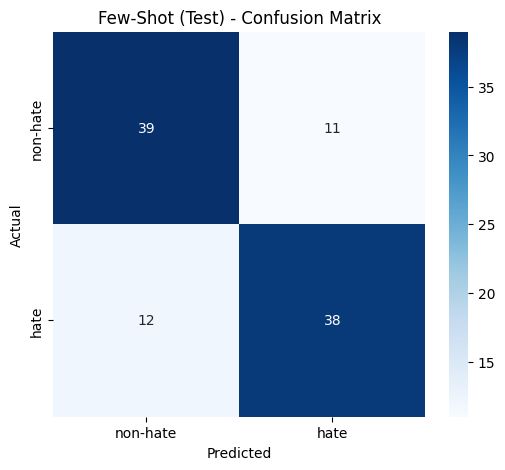

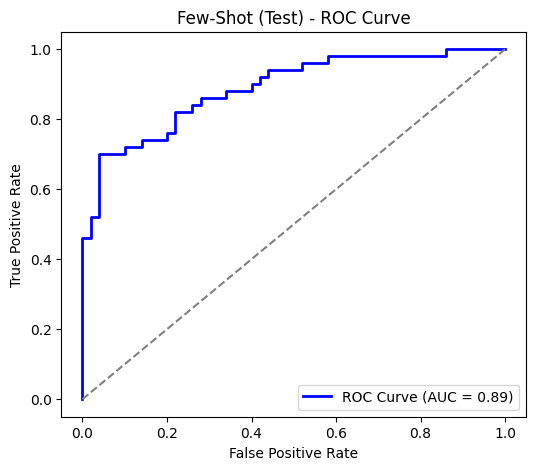

Few-Shot (Test) Accuracy: 0.7700

Chain-of-Thought (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.92      0.96      0.94        50
        hate       0.96      0.92      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



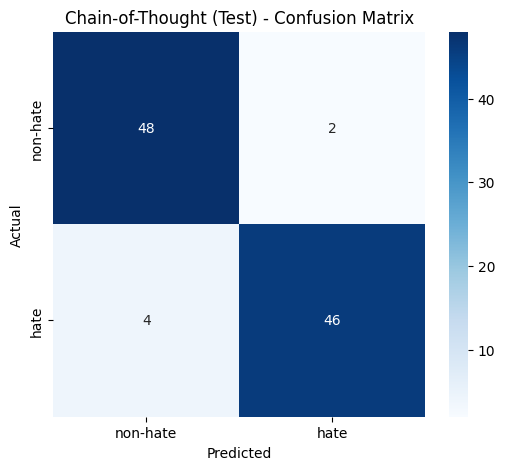

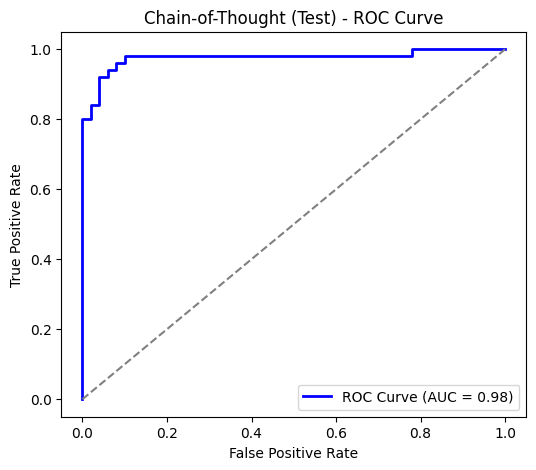

Chain-of-Thought (Test) Accuracy: 0.9400

Combined Prompting (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.80      0.78      0.79        50
        hate       0.78      0.80      0.79        50

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100



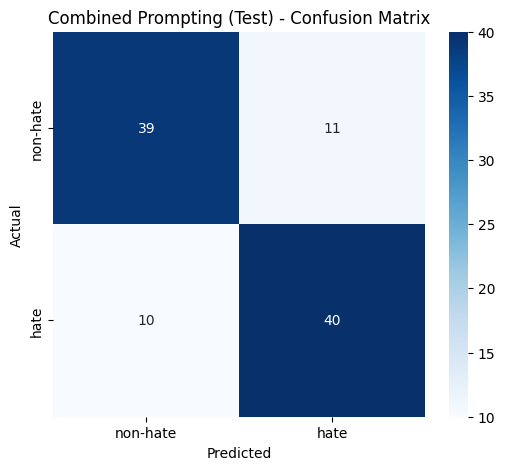

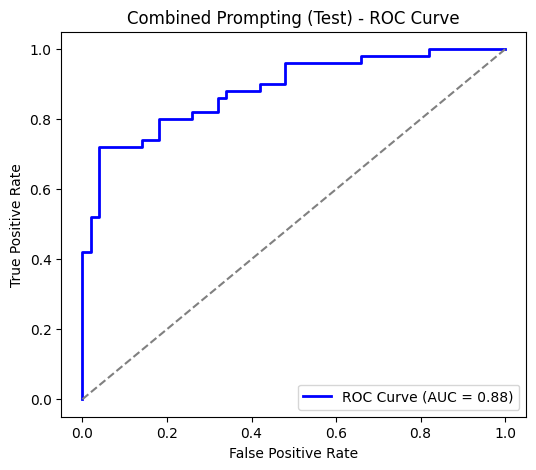

Combined Prompting (Test) Accuracy: 0.7900

🧠 LIME Explanation for Test Sample 5:
Text: ye movie bilkul bakwas thi, time waste mat karo.



In [ ]:
import os       #padhna
import torch
import pandas as pd
import numpy as np
import re
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sentence_transformers import SentenceTransformer
from lime.lime_text import LimeTextExplainer

# ------------------------------
# Load and Preprocess Dataset
# ------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, encoding="latin1")
    
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df["Text"] = df["Text"].apply(clean_text)
    label_map = {"hate": 1, "non-hate": 0}
    df["Label"] = df["Label"].map(label_map)
    df = df.dropna(subset=["Label"])
    
    return df

train_file_path = "dataset.csv"
test_file_path = "TEST.csv"

df_train = load_and_preprocess(train_file_path)
df_test = load_and_preprocess(test_file_path)

# ------------------------------
# Load Model & Tokenizer
# ------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------
# FAISS-based RAG Setup
# ------------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df_train["Text"].tolist()
labels = df_train["Label"].tolist()

embeddings = embedding_model.encode(texts, convert_to_numpy=True)
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

def retrieve_similar_examples(query_text, top_k=3):
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    distances, indices = faiss_index.search(query_embedding, top_k)
    examples = [(texts[i], labels[i]) for i in indices[0]]
    return examples

# ------------------------------
# Prompting Techniques
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# ✅ Combined Prompt
def combined_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Learn from these examples:\n\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += "Now, let's analyze this text step-by-step:\n"
    prompt += f"Text: {text}\nReasoning:"
    return prompt

# ------------------------------
# Run Inference
# ------------------------------
def run_inference(df, prompt_func):
    all_preds = []
    all_labels = []
    all_probs = []
    for _, row in df.iterrows():
        text, true_label = row["Text"], int(row["Label"])
        prompt_text = prompt_func(text)
        
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        
        pred = np.argmax(logits, axis=-1)[0]
        
        all_preds.append(pred)
        all_labels.append(true_label)
        all_probs.append(probs[0][1])
    
    return all_preds, all_labels, all_probs

# ------------------------------
# Evaluation
# ------------------------------
def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred, target_names=["non-hate", "hate"]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-hate", "hate"], yticklabels=["non-hate", "hate"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

# ------------------------------
# Run All Evaluations
# ------------------------------

# Train
zero_preds_train, zero_labels_train, zero_probs_train = run_inference(df_train, zero_shot_prompt)
few_preds_train, few_labels_train, few_probs_train = run_inference(df_train, few_shot_prompt)
cot_preds_train, cot_labels_train, cot_probs_train = run_inference(df_train, chain_of_thought_prompt)
combined_preds_train, combined_labels_train, combined_probs_train = run_inference(df_train, combined_prompt)

# Test
zero_preds_test, zero_labels_test, zero_probs_test = run_inference(df_test, zero_shot_prompt)
few_preds_test, few_labels_test, few_probs_test = run_inference(df_test, few_shot_prompt)
cot_preds_test, cot_labels_test, cot_probs_test = run_inference(df_test, chain_of_thought_prompt)
combined_preds_test, combined_labels_test, combined_probs_test = run_inference(df_test, combined_prompt)

# Evaluate All
print("\n---- EVALUATION ON TRAIN DATA ----")
evaluate_model("Zero-Shot (Train)", zero_labels_train, zero_preds_train, zero_probs_train)
evaluate_model("Few-Shot (Train)", few_labels_train, few_preds_train, few_probs_train)
evaluate_model("Chain-of-Thought (Train)", cot_labels_train, cot_preds_train, cot_probs_train)
evaluate_model("Combined Prompting (Train)", combined_labels_train, combined_preds_train, combined_probs_train)

print("\n---- EVALUATION ON TEST DATA ----")
evaluate_model("Zero-Shot (Test)", zero_labels_test, zero_preds_test, zero_probs_test)
evaluate_model("Few-Shot (Test)", few_labels_test, few_preds_test, few_probs_test)
evaluate_model("Chain-of-Thought (Test)", cot_labels_test, cot_preds_test, cot_probs_test)
evaluate_model("Combined Prompting (Test)", combined_labels_test, combined_preds_test, combined_probs_test)

# ------------------------------
# LIME and SHAP Explanations
# ------------------------------
class_names = ["non-hate", "hate"]

def predict_proba_lime(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

def explain_with_lime(index=0):
    explainer = LimeTextExplainer(class_names=class_names)
    test_text = df_test.iloc[index]["Text"]
    print(f"\n🧠 LIME Explanation for Test Sample {index}:")
    print(f"Text: {test_text}\n")
    exp = explainer.explain_instance(test_text, predict_proba_lime, num_features=10)
    exp.show_in_notebook(text=True)

# Run Explanations
explain_with_lime(index=5)


In [10]:
import os
import torch
import pandas as pd
import numpy as np
import re
import faiss
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
from lime.lime_text import LimeTextExplainer

# ------------------------------
# Load and Preprocess Dataset (for retrieval and explanation)
# ------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, encoding="latin1")
    
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df["Text"] = df["Text"].apply(clean_text)
    label_map = {"hate": 1, "non-hate": 0}
    df["Label"] = df["Label"].map(label_map)
    df = df.dropna(subset=["Label"])
    return df

# Change these paths if needed:
train_file_path = "dataset.csv"
test_file_path = "TEST.csv"

df_train = load_and_preprocess(train_file_path)
df_test = load_and_preprocess(test_file_path)
# For LIME explanations we use test texts:
test_texts = df_test["Text"].tolist()

# ------------------------------
# Load Model & Tokenizer
# ------------------------------
saved_model_dir = "./results_XLM"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    st.write("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    st.write("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
st.write("Using device:", device)
model.to(device)
model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------
# FAISS-based RAG Setup for Retrieval (used in few-shot and combined prompts)
# ------------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df_train["Text"].tolist()
labels = df_train["Label"].tolist()

embeddings = embedding_model.encode(texts, convert_to_numpy=True)
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

def retrieve_similar_examples(query_text, top_k=3):
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    distances, indices = faiss_index.search(query_embedding, top_k)
    examples = [(texts[i], labels[i]) for i in indices[0]]
    return examples

# ------------------------------
# Prompting Techniques
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

def combined_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Learn from these examples:\n\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += "Now, let's analyze this text step-by-step:\n"
    prompt += f"Text: {text}\nReasoning:"
    return prompt

# ------------------------------
# Inference for a Single Input Text
# ------------------------------
def predict_single(text, prompt_func):
    prompt_text = prompt_func(text)
    inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.cpu().numpy()
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    pred = np.argmax(logits, axis=-1)[0]
    return pred, probs[0][1]

# ------------------------------
# LIME Explanation Function
# ------------------------------
def predict_proba_lime(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

def explain_with_lime(text):
    explainer = LimeTextExplainer(class_names=["non-hate", "hate"])
    exp = explainer.explain_instance(text, predict_proba_lime, num_features=10)
    # Get the explanation as HTML and display it in Streamlit:
    html_exp = exp.as_html()
    st.components.v1.html(html_exp, height=800, scrolling=True)

# ------------------------------
# Streamlit GUI
# ------------------------------
st.title("Hate Speech Detection with Explainable AI")

st.sidebar.header("Configuration")
prompt_method = st.sidebar.selectbox("Select Prompting Method:", 
                                     ("Zero-Shot", "Few-Shot", "Chain-of-Thought", "Combined"))

input_text = st.text_area("Enter text to classify:", "Type your text here...")
if st.button("Predict"):
    if prompt_method == "Zero-Shot":
        pred, prob = predict_single(input_text, zero_shot_prompt)
    elif prompt_method == "Few-Shot":
        pred, prob = predict_single(input_text, few_shot_prompt)
    elif prompt_method == "Chain-of-Thought":
        pred, prob = predict_single(input_text, chain_of_thought_prompt)
    elif prompt_method == "Combined":
        pred, prob = predict_single(input_text, combined_prompt)
    
    label_str = "hate" if pred == 1 else "non-hate"
    st.write(f"**Prediction:** {label_str}")
    st.write(f"**Probability for 'hate':** {prob:.4f}")

    if st.checkbox("Show LIME Explanation"):
        st.write("Generating LIME explanation...")
        explain_with_lime(input_text)


2025-04-04 17:59:11.642 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 17:59:11.726 
  command:

    streamlit run /home/srmist20/.local/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-04-04 17:59:11.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 17:59:11.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 17:59:11.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 17:59:12.661 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 17:59:12.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 17:59:12.662 Thread 'MainThr

In [11]:
streamlit run app.py

SyntaxError: invalid syntax (3737097518.py, line 1)